In [8]:
import pandas as pd
import numpy as np
#from plotnine import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss 
from sklearn.model_selection import cross_val_score
    
import statsmodels.api as sm
import itertools

from scipy.stats import mode

import random
 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

import xgboost as xgb


In [9]:
def reshape_n(df, n=5):
    if ((df.shape[0] <n) or (n%2==0)):
        print("Input error!")
        return df
    r = df.shape[0]
    c = df.shape[1]
    newColumns = []
    for i in range(0, n):
        for colName in df.columns:
            newColumns.append(str(colName) + str(i+1))
    result = pd.DataFrame(columns = newColumns, data = np.zeros((r, c*n)))
    for i in range(n//2, r-n//2):
        for j in range(0, n):
            k = j-n//2
            result.iloc[i,c*j:c*(j+1)]= df.iloc[i+k, :].values
    return result


In [10]:
naif = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\featuresTrain.xlsx')

In [11]:
eeg = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\spectrogram_eeg_features30Train.xlsx')
acc = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTrain.xlsx')
pulse = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.csv')
pulse = pulse.iloc[:, 1:]  
#pulse = pulse.drop(columns = ['max_r', 'min_r', 'max_ir', 'min_ir']) #remove features that are double
#pulse = pulse.drop(columns =['BPMlessthan30_ir', 'BPMlessthan30_r']) # remove features with no importance 
eeg.drop(columns=["eeg1_Above100Hz0", "eeg2_Above100Hz0", "eeg3_Above100Hz0", "eeg4_Above100Hz0"], inplace=True)
#pulseAmp = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_ampTrain.csv')
#pulseAmp = pulseAmp.iloc[:, 1:]


In [12]:
pulse.columns

Index(['BPM_ir', 'IBI_ir', 'SDNN_ir', 'SDSD_ir', 'RMSSD_ir', 'pNN60_ir',
       'pNN20_ir', 'MAD_ir', 'BPMlessthan30_ir', 'max_ir', 'min_ir', 'BPM_r',
       'IBI_r', 'SDNN_r', 'SDSD_r', 'RMSSD_r', 'pNN60_r', 'pNN20_r', 'MAD_r',
       'BPMlessthan30_r', 'max_r', 'min_r'],
      dtype='object')

In [13]:
df = pd.concat([eeg, acc, pulse, naif], axis=1)


In [42]:
dfa = pd.concat([eeg, acc, pulse, naif, pulseAmp], axis=1)

In [43]:
dfa.columns[28:50]

Index(['BPM_ir', 'IBI_ir', 'SDNN_ir', 'SDSD_ir', 'RMSSD_ir', 'pNN60_ir',
       'pNN20_ir', 'MAD_ir', 'BPM_r', 'IBI_r', 'SDNN_r', 'SDSD_r', 'RMSSD_r',
       'pNN60_r', 'pNN20_r', 'MAD_r', 'mean_eeg_1', 'std_eeg_1', 'min_eeg_1',
       'max_eeg_1', '25%_eeg_1', '50%_eeg_1'],
      dtype='object')

In [14]:
train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

In [28]:
errors = []
Lk = []
La = []

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

r = [3, 5, 7, 9, 11]

for i in r:
    train5 = reshape_n(train.iloc[:,:-1], i)
    train5["Y"]= train.iloc[:,-1]

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(test.iloc[:,:-1], i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
          
    xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering only one epoch
log loss =  0.7112616548593073
kappa =  0.6481903133115836
accuracy =  0.7408167921514944


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  3  epochs
log loss =  0.6144416170129664
kappa =  0.704377782967301
accuracy =  0.7824301197946377


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  5  epochs
log loss =  0.6146555564059356
kappa =  0.7021318471786651
accuracy =  0.7806937471474212


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  7  epochs
log loss =  0.6108590127670228
kappa =  0.7049457851705652
accuracy =  0.7827228118224352


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  9  epochs
log loss =  0.6089801103144198
kappa =  0.702750750259022
accuracy =  0.7813284638210454
considering  11  epochs
log loss =  0.6070592229998082
kappa =  0.7129564405419131
accuracy =  0.7888368907658942


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
 r.insert(0, 1)

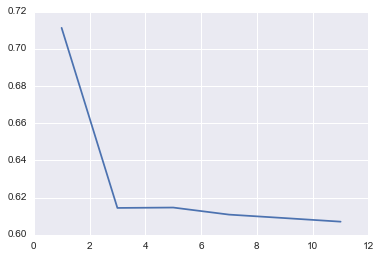

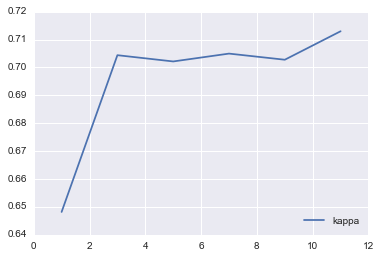

In [30]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [33]:
errors = []
Lk = []
La = []

X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("considering only one epoch")
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)
Lk.append(k)
La.append(a)

r = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for i in r:
    train5 = reshape_n(train.iloc[:,:-1], i)
    train5["Y"]= train.iloc[:,-1]

    for j in range(0, i//2):
      train5.drop([train5.shape[0]-(i+1)], inplace=True)
    
    test5 = reshape_n(test.iloc[:,:-1], i)
    test5["Y"]= test.iloc[:,-1].values
    for j in range(0, i//2):
      test5.drop([test5.shape[0]-(i+1)], inplace=True)
      
    X = train5.iloc[:,:-1]
    y = train5.iloc[:,-1]
    X_test = test5.iloc[:,:-1]
    y_true = test5.iloc[:,-1]
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering only one epoch
log loss =  0.7365930790570688
kappa =  0.6500303924229641
accuracy =  0.742299794661191


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  3  epochs
log loss =  0.6395421070551731
kappa =  0.7102063541106889
accuracy =  0.7867655447803765


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  5  epochs
log loss =  0.6345323343079022
kappa =  0.7152280046605096
accuracy =  0.7903925148334094


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  7  epochs
log loss =  0.6351625698814416
kappa =  0.7130812067465442
accuracy =  0.7887709688462855


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  9  epochs
log loss =  0.6314540491602866
kappa =  0.7125095971872804
accuracy =  0.7885186030586624


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  11  epochs
log loss =  0.6321143030558676
kappa =  0.7216579296679757
accuracy =  0.7953429973747289


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  13  epochs
log loss =  0.6243029429858097
kappa =  0.7193243794893144
accuracy =  0.7934931506849315


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  15  epochs
log loss =  0.6240693668764069
kappa =  0.7219510879454714
accuracy =  0.7957529398333143


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  17  epochs
log loss =  0.6205331297616722
kappa =  0.72081410122745
accuracy =  0.7947019867549668


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


considering  19  epochs
log loss =  0.6324855365028789
kappa =  0.7169432839060098
accuracy =  0.7918236839100149
considering  21  epochs
log loss =  0.6422925560275619
kappa =  0.7129084211931155
accuracy =  0.78905893101873


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


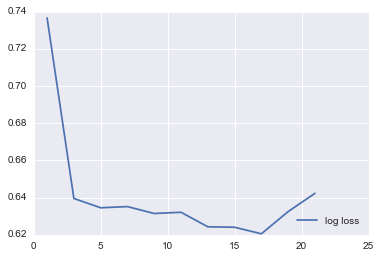

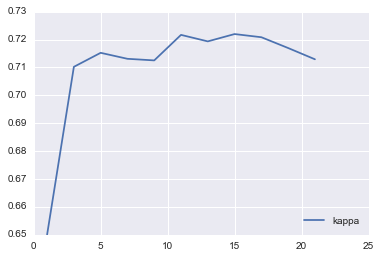

In [34]:
r.insert(0, 1)
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)

In [7]:
#Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)
i=11
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]

In [10]:
print(X.shape)
print(y.shape)
print(y.unique())

(35059, 1243)
(35059,)
[0 1 2 3 4]


In [ ]:
Around best score: n_estimators = 180, regularization 5

In [17]:
%%time
errors = []
Lk = []
La = []

r = [5, 8, 9, 10, 11, 12, 13, 14, 15]

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

for n_estimators=  5
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992
for n_estimators=  8
log loss =  0.6045792760613042
kappa =  0.7127328098916936
accuracy =  0.7886086063234791
for n_estimators=  9
log loss =  0.599938785325976
kappa =  0.7168089916759459
accuracy =  0.7916904462960849
for n_estimators=  10
log loss =  0.6005333105498049
kappa =  0.7190684897674926
accuracy =  0.7931742951717841
for n_estimators=  11
log loss =  0.5982991165759909
kappa =  0.715939655656635
accuracy =  0.7910055929688392
for n_estimators=  12
log loss =  0.5951443764534134
kappa =  0.7186229354473718
accuracy =  0.7928318685081611
for n_estimators=  13
log loss =  0.5983425103804749
kappa =  0.7189785405787055
accuracy =  0.7929460107293688
for n_estimators=  14
log loss =  0.5963545501345998
kappa =  0.7185001830228607
accuracy =  0.7928318685081611
for n_estimators=  15
log loss =  0.600014842047674
kappa =  0.7212824234443656
accuracy =  0.7948864284898984

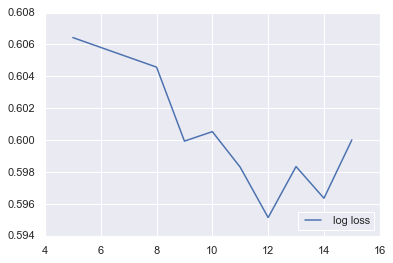

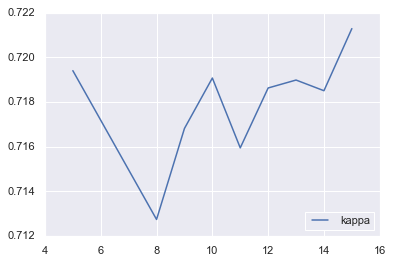

In [18]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

Now on n_estimators

In [15]:
%%time
errors = []
Lk = []
La = []

r = range(170, 190, 1)

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=10)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

for n_estimators=  170
log loss =  0.5981614556573986
kappa =  0.7157342917275691
accuracy =  0.7906631663052163
for n_estimators=  171
log loss =  0.5984786300355652
kappa =  0.7165142301944145
accuracy =  0.7912338774112544
for n_estimators=  172
log loss =  0.5987538040768383
kappa =  0.7166776960827891
accuracy =  0.791348019632462
for n_estimators=  173
log loss =  0.5992643120285742
kappa =  0.7171629918769221
accuracy =  0.7916904462960849
for n_estimators=  174
log loss =  0.5991825052591631
kappa =  0.7182006338137839
accuracy =  0.7924894418445383
for n_estimators=  175
log loss =  0.5990856572743384
kappa =  0.7187886876797521
accuracy =  0.7929460107293688
for n_estimators=  176
log loss =  0.5992637366503075
kappa =  0.7181826240522999
accuracy =  0.7924894418445383
for n_estimators=  177
log loss =  0.5994362106637635
kappa =  0.7189173550440073
accuracy =  0.7930601529505764
for n_estimators=  178
log loss =  0.5993578552169736
kappa =  0.719045101798935
accuracy =  0.79

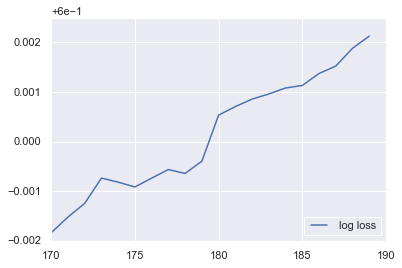

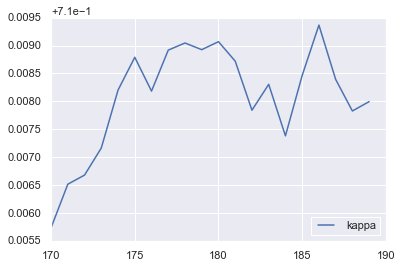

In [16]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [19]:
%%time
errors = []
Lk = []
La = []

r = [5, 10, 14, 15]

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = 178, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for reg_lambda= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

for reg_lambda=  5
log loss =  0.6053460744124239
kappa =  0.7198540980843968
accuracy =  0.7937450062778222
for reg_lambda=  10
log loss =  0.5993578552169736
kappa =  0.719045101798935
accuracy =  0.7931742951717841
for reg_lambda=  14
log loss =  0.5959810506044567
kappa =  0.7176011758034874
accuracy =  0.7921470151809155
for reg_lambda=  15
log loss =  0.599148521201221
kappa =  0.7205739898859299
accuracy =  0.7943157173838603
Wall time: 1h 2min 50s


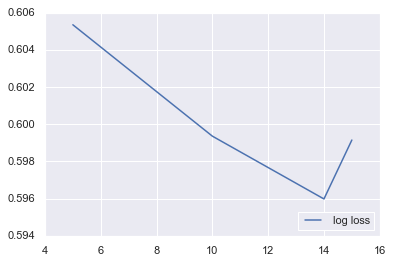

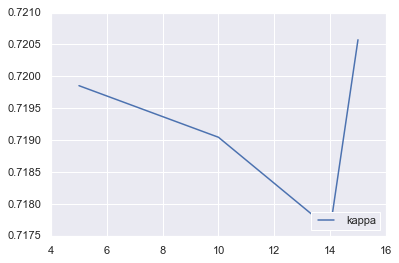

In [20]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()

plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

Resuming old thread

In [36]:
errors = []
Lk = []
La = []

r = range(10, 500 , 10)

for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, warm_start=True)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    xbc.fit(X, y).n_estimators += 10

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  10
log loss =  0.9824693852629703
kappa =  0.6502332207149977
accuracy =  0.7415820111859377


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  20
log loss =  0.7891275199403802
kappa =  0.6618292188900556
accuracy =  0.7500285355553019


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  30
log loss =  0.6955273778901404
kappa =  0.6775739024792471
accuracy =  0.7622417532245177


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  40
log loss =  0.6550531071676551
kappa =  0.6900234277655801
accuracy =  0.771601415363543


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  50
log loss =  0.6345224660584097
kappa =  0.691702092988979
accuracy =  0.7728569797968269


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  60
log loss =  0.6258373713162702
kappa =  0.6912880739446804
accuracy =  0.7724004109119963


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  70
log loss =  0.6177249742773261
kappa =  0.6979011085827476
accuracy =  0.7774226686451319


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  80
log loss =  0.6112047357619916
kappa =  0.7049871818939144
accuracy =  0.7827873530418902


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  90
log loss =  0.607499615408862
kappa =  0.709000268962936
accuracy =  0.7858691930144961


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  100
log loss =  0.6070592229998082
kappa =  0.7129564405419131
accuracy =  0.7888368907658942


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  110
log loss =  0.6066953947836593
kappa =  0.7144819405077073
accuracy =  0.7899783129779705


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.6084892356102274
kappa =  0.7163606786066179
accuracy =  0.791348019632462


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  130
log loss =  0.6106290467241953
kappa =  0.7188981599880631
accuracy =  0.7932884373929917


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  140
log loss =  0.6166908316598455
kappa =  0.7170786833522892
accuracy =  0.7919187307385002


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  150
log loss =  0.6207472471339629
kappa =  0.7181754142114944
accuracy =  0.7928318685081611


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  160
log loss =  0.6224779050881721
kappa =  0.7195402438540016
accuracy =  0.7937450062778222


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  170
log loss =  0.626628714786645
kappa =  0.719101727663049
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  180
log loss =  0.6321143030558676
kappa =  0.7216579296679757
accuracy =  0.7953429973747289


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  190
log loss =  0.6352768290933914
kappa =  0.7216055086748873
accuracy =  0.7952288551535213


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  200
log loss =  0.6381782097930583
kappa =  0.7211436803974731
accuracy =  0.7948864284898984


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  210
log loss =  0.6419448228768974
kappa =  0.7226490987849138
accuracy =  0.7960278507019747


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  220
log loss =  0.6452712231765992
kappa =  0.7236143614158422
accuracy =  0.7967127040292205


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  230
log loss =  0.648524599123075
kappa =  0.7231392218614955
accuracy =  0.7963702773655975


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  240
log loss =  0.6521031259115087
kappa =  0.7241173315038751
accuracy =  0.7970551306928433


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  250
log loss =  0.6553704103977813
kappa =  0.7261231064474428
accuracy =  0.7985389795685424


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  260
log loss =  0.6578860077299948
kappa =  0.7272343578805749
accuracy =  0.7993379751169958


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  270
log loss =  0.66123282243177
kappa =  0.7278202163159542
accuracy =  0.7997945440018263


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  280
log loss =  0.664549875559046
kappa =  0.7268106892607163
accuracy =  0.798995548453373


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  290
log loss =  0.6671634522260086
kappa =  0.7264769620312701
accuracy =  0.7987672640109577


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  300
log loss =  0.6707836514828428
kappa =  0.7262274556566863
accuracy =  0.7985389795685424


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  310
log loss =  0.6739803170293677
kappa =  0.7256234321439765
accuracy =  0.7980824106837119


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  320
log loss =  0.67660783282511
kappa =  0.725615062421643
accuracy =  0.7980824106837119


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  330
log loss =  0.6796034779831235
kappa =  0.7256406120344676
accuracy =  0.7980824106837119


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  340
log loss =  0.6829155090210953
kappa =  0.7263612604815823
accuracy =  0.79865312178975


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  350
log loss =  0.6861745049173499
kappa =  0.7268462542262766
accuracy =  0.798995548453373


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  360
log loss =  0.689095421662188
kappa =  0.7276448003133367
accuracy =  0.7995662595594111


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  370
log loss =  0.6916870469914217
kappa =  0.7261493569293465
accuracy =  0.7984248373473348


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  380
log loss =  0.6936667238937615
kappa =  0.7267403684404221
accuracy =  0.7988814062321653


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  390
log loss =  0.696573289752853
kappa =  0.7267209458214867
accuracy =  0.7988814062321653


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  400
log loss =  0.6996342898326563
kappa =  0.7273373135800636
accuracy =  0.7993379751169958


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  410
log loss =  0.7016625697535597
kappa =  0.7271509776963712
accuracy =  0.7992238328957881


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  420
log loss =  0.7044588621553853
kappa =  0.7282147360530937
accuracy =  0.8000228284442416


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  430
log loss =  0.7069143016715345
kappa =  0.7276039936357956
accuracy =  0.7995662595594111


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  440
log loss =  0.7088032159571778
kappa =  0.7287103847696134
accuracy =  0.8003652551078644


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  450
log loss =  0.7106005472981862
kappa =  0.7287540044349627
accuracy =  0.8003652551078644


KeyboardInterrupt: 

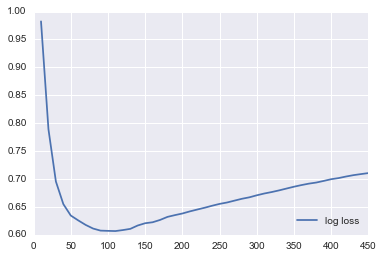

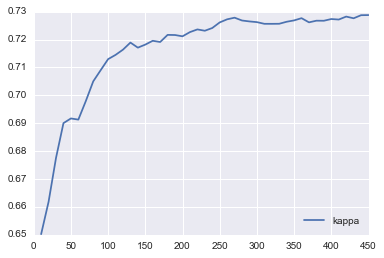

In [38]:
rr = range(10, 460 , 10)
plt.plot(rr, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(rr, La, label = "accuracy")
plt.plot(rr, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()


n=100. Score: 0.692 compared to 0.691 with N=5
- log loss =  0.6070592229998082
- kappa =  0.7129564405419131
- accuracy =  0.7888368907658942

log loss minimized for n_estimators=  110
- log loss =  0.6066953947836593
- kappa =  0.7144819405077073
- accuracy =  0.7899783129779705

1st max kappa
- for n_estimators=  270
- log loss =  0.66123282243177
- kappa =  0.7278202163159542
- accuracy =  0.7997945440018263

let's see if regularisation help for n = 270

In [39]:
errors = []
Lk = []
La = []

r = range(120, 370 , 50)
xbc = xgb.XGBClassifier(n_estimators = 120, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, warm_start=True, lambda_reg=5)

for i in r:
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    xbc.fit(X, y).n_estimators += 50

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.6084892356102274
kappa =  0.7163606786066179
accuracy =  0.791348019632462


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  170
log loss =  0.626628714786645
kappa =  0.719101727663049
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  220
log loss =  0.6452712231765992
kappa =  0.7236143614158422
accuracy =  0.7967127040292205


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  270
log loss =  0.66123282243177
kappa =  0.7278202163159542
accuracy =  0.7997945440018263


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  320
log loss =  0.67660783282511
kappa =  0.725615062421643
accuracy =  0.7980824106837119


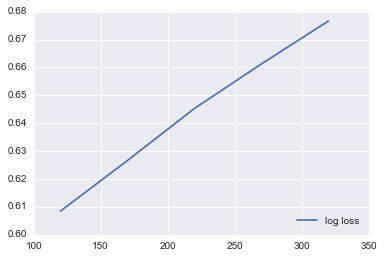

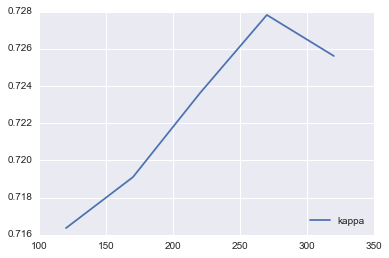

In [40]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [13]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, max_depth=8, learning_rate=0.1, subsample=0.7)

parametres = { 'reg_lambda' : [0, 1, 5], 'gamma': [0, 0.01], 'reg_alpha' : [0, 1, 5]}
    
ck_score = make_scorer(cohen_kappa_score)
grid = GridSearchCV(estimator=xbc, param_grid=parametres, scoring='neg_log_loss', n_jobs=-1, verbose=2)

grid_fitted = grid.fit(X,y)
print(grid_fitted.best_params_)

y_pred = grid.predict(X_test)

print("kappa: ", cohen_kappa_score(y_true, y_pred))
print("accurancy for n_estimators  = " , accuracy_score(y_true, y_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 317.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 549.4min finished


{'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5}
kappa:  0.7110410355251684
accurancy for n_estimators  =  0.7865540463417419


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
ll = log_loss(y_true, grid.predict_proba(X_test))
ll

0.5847366368019232

Reference without regularization n: 180
- log loss =  0.632
- kappa =  0.722
- accuracy =  0.795
n estimator : 180, {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5}
- log loss: 0.585
- kappa:  0.711
- accurancy: 0.787
for n_estimators=  240 {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5} // log loss min 
- log loss =  0.5805557190155572
- kappa =  0.719 /  
- accuracy =  0.792
- challenge score : 0.69501856567217. Delta test/Challenge 0,7186789415933239- 0,69501856567217= 0.024
for n_estimators=  300 {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5} // point d'interret
- log loss =  0.580970969589507
- kappa =  0.7218863968707475
- accuracy =  0.7947722862686908
for n_estimators=  340 {'gamma': 0.01, 'reg_alpha': 5, 'reg_lambda': 5} // point d'interret
- log loss =  0.5826844474036029
- kappa =  0.7242661136765393
- accuracy =  0.7965985618080128
- Your score is : 0.69083908105379. Moins que n = 240 faut arreter la.


In [16]:
errors = []
Lk = []
La = []

r = range(100, 420 , 20)

xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, warm_start=True, reg_lambda=5, reg_alpha=5, gamma=0.01)
for i in r:

    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    xbc.fit(X, y).n_estimators += 20

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  100
log loss =  0.5943547207077089
kappa =  0.6953217264061219
accuracy =  0.7745691131149413


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.590197229433441
kappa =  0.6999629943324568
accuracy =  0.7781075219723775


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  140
log loss =  0.5869327156193311
kappa =  0.7032713552774696
accuracy =  0.7806186508389453


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  160
log loss =  0.5850630449359749
kappa =  0.7070735575692861
accuracy =  0.783472206369136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  180
log loss =  0.5847366368019232
kappa =  0.7110410355251684
accuracy =  0.7865540463417419


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  200
log loss =  0.582801791101916
kappa =  0.7143070254961257
accuracy =  0.7890651752083095


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  220
log loss =  0.5822019173799158
kappa =  0.7163987924076292
accuracy =  0.7906631663052163


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  240
log loss =  0.5805557190155572
kappa =  0.7186789415933239
accuracy =  0.7923752996233306


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  260
log loss =  0.5807101228630106
kappa =  0.7201279602809887
accuracy =  0.7935167218354069


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  280
log loss =  0.5814518261065713
kappa =  0.7206615574207387
accuracy =  0.7938591484990298


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  300
log loss =  0.580970969589507
kappa =  0.7218863968707475
accuracy =  0.7947722862686908


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  320
log loss =  0.582533653043016
kappa =  0.7226209636720686
accuracy =  0.7953429973747289


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  340
log loss =  0.5826844474036029
kappa =  0.7242661136765393
accuracy =  0.7965985618080128


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  360
log loss =  0.5850286402342671
kappa =  0.7241194545510675
accuracy =  0.7964844195868052


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  380
log loss =  0.586012107670894
kappa =  0.724427042245402
accuracy =  0.7967127040292205


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  400
log loss =  0.588075511257475
kappa =  0.7253034446344182
accuracy =  0.7973975573564661


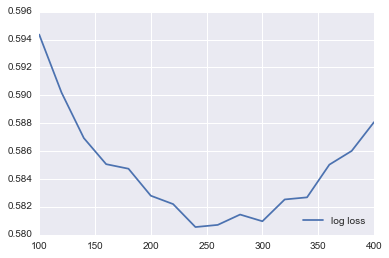

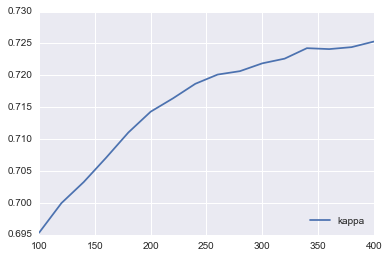

In [17]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

#### trying with 17 epochs (to make sure)
- submitted for estimators = 150 | 180 with score a bit below 0.70

In [7]:
#Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)
i=17
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]

In [8]:
X.shape

(35056, 1921)

In [9]:
errors = []
Lk = []
La = []

r = range(10, 210 , 10)


for i in r:
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-1, warm_start=True, lambda_reg=5)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("for n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)
    



C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  10
log loss =  0.9625536626803328
kappa =  0.6717997514835425
accuracy =  0.7589632336149806


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  20
log loss =  0.761683596277256
kappa =  0.6825550017918228
accuracy =  0.7667275633706325


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  30
log loss =  0.6748793622107505
kappa =  0.6876622140614548
accuracy =  0.7704955469285225


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  40
log loss =  0.6378810095244971
kappa =  0.6946384995809091
accuracy =  0.7756337063256451


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  50
log loss =  0.6152916663766782
kappa =  0.6997561595972327
accuracy =  0.7794016898835351


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  60
log loss =  0.6040492944089093
kappa =  0.7023227437103737
accuracy =  0.781228591002512


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  70
log loss =  0.5960098088023064
kappa =  0.7039463327631735
accuracy =  0.7823704042018725


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  80
log loss =  0.5922166254881782
kappa =  0.7075261466132107
accuracy =  0.784996574560402


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  90
log loss =  0.5911915861204144
kappa =  0.7106478852977616
accuracy =  0.7872802009591231


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  100
log loss =  0.594254732468842
kappa =  0.7136797501582159
accuracy =  0.7895638273578443


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  110
log loss =  0.5968741104844192
kappa =  0.7137883615475002
accuracy =  0.7896780086777803


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  120
log loss =  0.599550031839922
kappa =  0.7147794020883436
accuracy =  0.7904772779173327


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  130
log loss =  0.6019848179209207
kappa =  0.716240509527251
accuracy =  0.7915049097967573


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  140
log loss =  0.6050395928337824
kappa =  0.7165602958451522
accuracy =  0.7917332724366294


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  150
log loss =  0.6096242395361352
kappa =  0.7193654248905181
accuracy =  0.7937885361954784


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  160
log loss =  0.613080168420413
kappa =  0.7191047470350179
accuracy =  0.7935601735556063


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  170
log loss =  0.6180097216089501
kappa =  0.719327843494894
accuracy =  0.7936743548755424


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  180
log loss =  0.6205331297616722
kappa =  0.72081410122745
accuracy =  0.7947019867549668


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


for n_estimators=  190
log loss =  0.6247364707547473
kappa =  0.721309318148897
accuracy =  0.7950445307147751
for n_estimators=  200
log loss =  0.6284810938370645
kappa =  0.722819914459975
accuracy =  0.7961863439141357


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


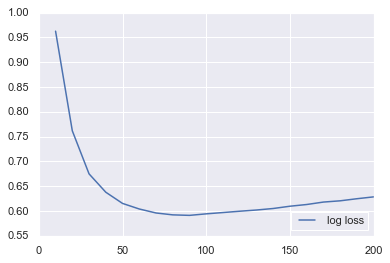

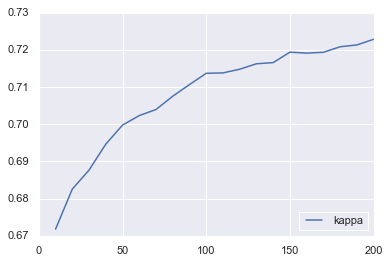

In [10]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

#### Illustrating best score
 
- your score 0.70273772415489
- xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, n_jobs=-2, reg_lambda=5)

In [23]:
#Explore for 11 epochs (epoch + 5 minutes before and 5 minutes after)
i=11
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]

In [24]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)


In [25]:
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))
errors.append(ll)
y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("for n_estimators= ", i)
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)

for n_estimators=  11
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1642   36  150    9   96]
 [  44   10   67    0  122]
 [  33    7 2322  260  249]
 [  26    0  429 2079    0]
 [  26    3  247    6  898]]
Normalized confusion matrix
[[0.85 0.02 0.08 0.   0.05]
 [0.18 0.04 0.28 0.   0.5 ]
 [0.01 0.   0.81 0.09 0.09]
 [0.01 0.   0.17 0.82 0.  ]
 [0.02 0.   0.21 0.01 0.76]]


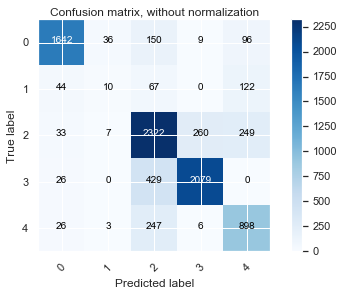

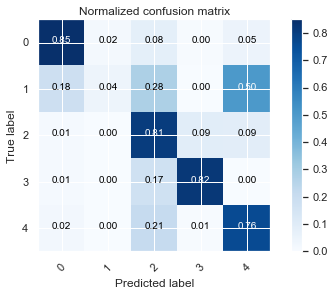

In [27]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

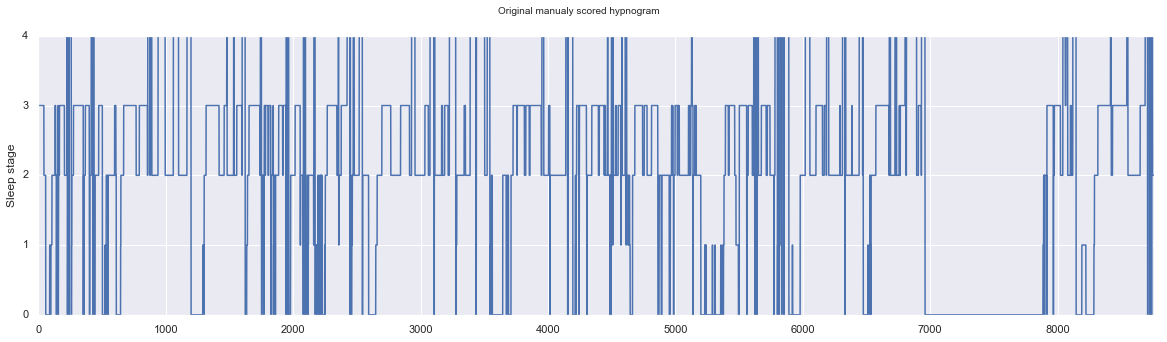

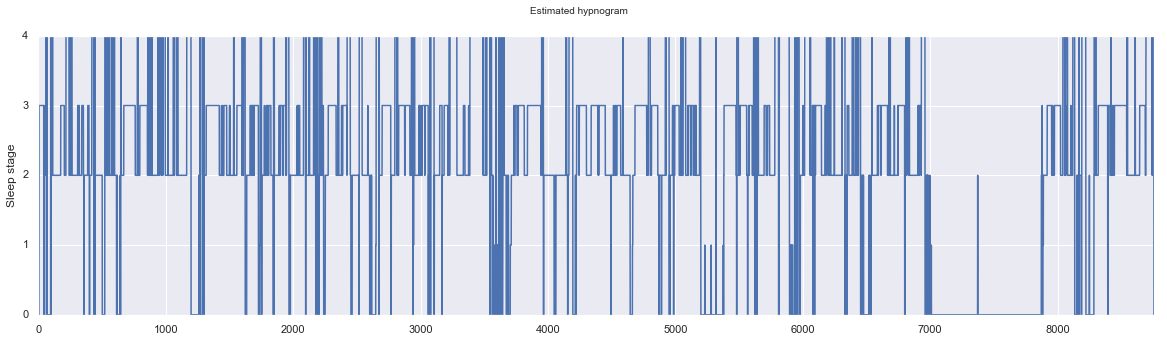

In [28]:
lim = y_pred.shape[0]

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(y_true)
plt.ylabel('Sleep stage')
plt.yticks([0, 1, 2, 3, 4, ])
ax.set_xlim([0, lim])
fig.suptitle("Original manualy scored hypnogram")
plt.show()


fig, ax = plt.subplots(figsize=(20,5))
plt.plot(y_pred)
plt.ylabel('Sleep stage')
plt.yticks([0, 1, 2, 3, 4, ])
ax.set_xlim([0, lim])
fig.suptitle("Estimated hypnogram")
plt.show()

## Trying stacking 

reference boosting
for n_estimators=  11
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992

XGboost on XGboost: exactly the same challenge score

In [15]:
naif = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\featuresTrain.xlsx')
eeg = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\spectrogram_eeg_features30Train.xlsx')
acc = pd.read_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\acc_featuresTrain.xlsx')
pulse = pd.read_csv('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\pulse_featuresTrain.csv')
pulse = pulse.iloc[:, 1:]  
eeg.drop(columns=["eeg1_Above100Hz0", "eeg2_Above100Hz0", "eeg3_Above100Hz0", "eeg4_Above100Hz0"], inplace=True)
df = pd.concat([eeg, acc, pulse, naif], axis=1)

train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]


In [4]:
i=11
train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)

test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]

X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
y = train5.iloc[:,-1]
y_true = test5.iloc[:,-1]

In [40]:
y.isna().any()

False

In [5]:
xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5)

In [6]:
xbc.fit(X, y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=180,
       n_jobs=-2, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=5, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [7]:
proba_X_test = xbc.predict_proba(X_test)
proba_X = xbc.predict_proba(X)
ll = log_loss(y_true, proba_X_test)

y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("for n_estimators= ", i)
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)

for n_estimators=  11
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [43]:
tmp = pd.DataFrame(proba_X)
i=11
train_proba11 = reshape_n(tmp, i)
train_proba11["Y"]= y.values

for j in range(0, i//2):
  train_proba11.drop([train_proba11.shape[0]-(i+1)], inplace=True)

In [48]:
tmp2 = pd.DataFrame(proba_X_test)
i=11
test_proba11 = reshape_n(tmp2, i)
test_proba11["Y"]= y_true.values
for j in range(0, i//2):
  test_proba11.drop([test_proba11.shape[0]-(i+1)], inplace=True)



In [44]:
train_proba11.shape

(35054, 56)

In [47]:
train_proba11["Y"].shape

(35054,)

In [49]:
train_proba11.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\proba11train.xlsx')
test_proba11.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\proba11test.xlsx')

In [56]:
X = train_proba11.iloc[:,:-1]
y = train_proba11.iloc[:,-1]
X_test = test_proba11.iloc[:,:-1]
y_true = test_proba11.iloc[:,-1]

In [57]:
xbcs = xgb.XGBClassifier(n_estimators = 17, random_state=42, learning_rate= 0.1, max_depth= 2,  subsample= 0.7, 
                            n_jobs=-2)

In [60]:
xbcs.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=17,
       n_jobs=-2, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [62]:
y_pred = xbcs.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
print("for n_estimators= 17")

print("kappa = ", k)
print("accuracy = ", a)

for n_estimators= 17
kappa =  0.7239401652315347
accuracy =  0.7964824120603015


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
errors = []
Lk = []
La = []

r = range(10, 21)


for i in r:
    xbcs = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 2,  subsample= 0.7, 
                            n_jobs=-1)
    xbcs.fit(train_proba11, y)
    ll = log_loss(y_true, xbcs.predict_proba(test_proba11))
    errors.append(ll)
    y_pred = xbcs.predict(test_proba11)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("n_estimators= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  10
log loss =  0.84270418470968
kappa =  0.7226350792682641
accuracy =  0.7955712818171442


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  11
log loss =  0.8215997511496107
kappa =  0.7228571249827118
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  12
log loss =  0.8051402936983484
kappa =  0.7228571249827118
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  13
log loss =  0.7924595574696659
kappa =  0.7228571249827118
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  14
log loss =  0.7831160741205588
kappa =  0.722840559645325
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  15
log loss =  0.7762208586481524
kappa =  0.7230202307038895
accuracy =  0.7957995662595594


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  16
log loss =  0.772188827041662
kappa =  0.7227908517493467
accuracy =  0.7956854240383517


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  17
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  18
log loss =  0.7713858805169064
kappa =  0.7219161386805839
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


n_estimators=  19
log loss =  0.7735349350073011
kappa =  0.7221291038139498
accuracy =  0.7951147129323136
n_estimators=  20
log loss =  0.777345753737596
kappa =  0.7227105831138435
accuracy =  0.7955712818171442


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


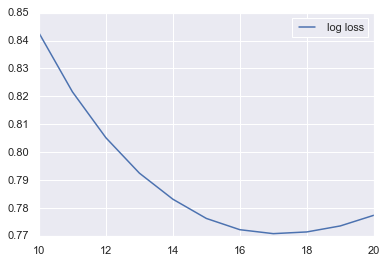

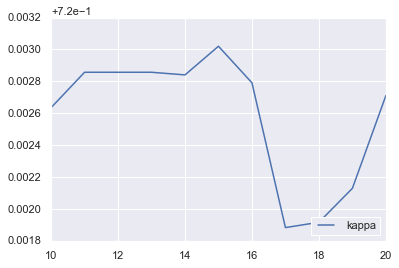

In [46]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='upper right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [43]:
errors = []
Lk = []
La = []

r = range(1, 5)


for i in r:
    xbcs = xgb.XGBClassifier(n_estimators = 17, random_state=42, learning_rate= 0.1, max_depth= i,  subsample= 0.7, 
                            n_jobs=-1)
    xbcs.fit(train_proba11, y)
    ll = log_loss(y_true, xbcs.predict_proba(test_proba11))
    errors.append(ll)
    y_pred = xbcs.predict(test_proba11)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("depth= ", i)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


depth=  1
log loss =  0.7705796844606706
kappa =  0.7221025782866585
accuracy =  0.7951147129323136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


depth=  2
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


depth=  3
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061
depth=  4
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


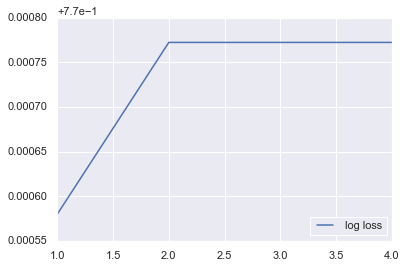

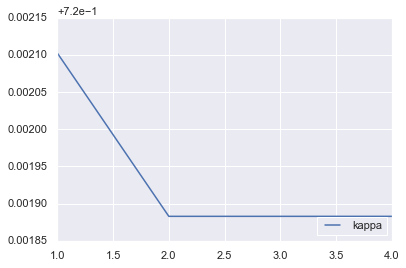

In [44]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [55]:
errors = []
Lk = []
La = []

r = range(1, 11)


for i in r:
    xbcs = xgb.XGBClassifier(n_estimators = 17, random_state=42, learning_rate= 0.1, max_depth= 2,  subsample= i/10, 
                            n_jobs=-1)
    xbcs.fit(train_proba11, y)
    ll = log_loss(y_true, xbcs.predict_proba(test_proba11))
    errors.append(ll)
    y_pred = xbcs.predict(test_proba11)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("subsample ", i/10)
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    
    Lk.append(k)
    La.append(a)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.1
log loss =  0.7732274554888416
kappa =  0.7191428350907432
accuracy =  0.7930601529505764


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.2
log loss =  0.7707632925208744
kappa =  0.721079840508342
accuracy =  0.7943157173838603


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.3
log loss =  0.7678237629051065
kappa =  0.7220827372996401
accuracy =  0.7951147129323136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.4
log loss =  0.768235843676694
kappa =  0.7221159644411517
accuracy =  0.7951147129323136


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.5
log loss =  0.768259534231945
kappa =  0.7230393385583629
accuracy =  0.7957995662595594


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.6
log loss =  0.7683464211390832
kappa =  0.7216872430782806
accuracy =  0.7947722862686908


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.7
log loss =  0.7707722029271239
kappa =  0.7218828920930072
accuracy =  0.7950005707111061


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.8
log loss =  0.7730607722546056
kappa =  0.7215697103734469
accuracy =  0.7947722862686908


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


subsample  0.9
log loss =  0.7762292236423073
kappa =  0.7234478690403868
accuracy =  0.7962561351443899
subsample  1.0
log loss =  0.7779861453709273
kappa =  0.7192538901301873
accuracy =  0.7932884373929917


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


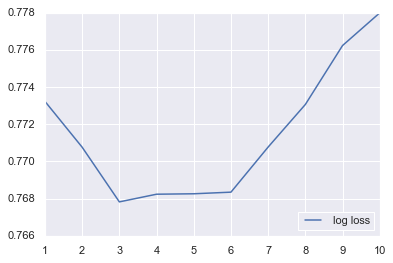

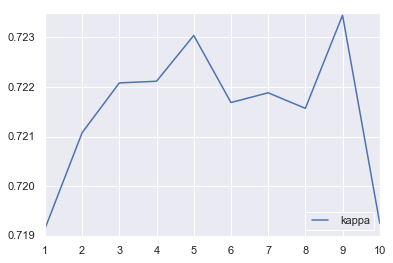

In [56]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

#### let's try by stacking logistic regression

In [70]:
train_proba11.shape

(35059, 55)

In [64]:
def predwake(X, y, X_test, y_true, L=[0.001, 0.01, 0.1, 1, 10, 100]):
    Lkappa_l1 = []
    Lkappa_l2 = []
    Lsparsity_l1 = []
    Lsparsity_l2 = []
    Lrecall_l1 = []
    Lrecall_l2 = []
    Lprecision_l1 = []
    Lprecision_l2 = []
    for C in L: 
        l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='liblinear')
        l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='liblinear')
        l1_LR.fit(X, y)
        l2_LR.fit(X, y)
        y_pred_l1 = l1_LR.predict(X_test)
        y_pred_l2 = l2_LR.predict(X_test)
        coef_l1_LR = l1_LR.coef_.ravel()
        coef_l2_LR = l2_LR.coef_.ravel()
        sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
        sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
        kappa_l1 = cohen_kappa_score(y_true, y_pred_l1)
        kappa_l2 = cohen_kappa_score(y_true, y_pred_l2)
        #
        Lsparsity_l1.append(sparsity_l1_LR)
        Lsparsity_l2.append(sparsity_l2_LR)

        Lkappa_l1.append(kappa_l1)
        Lkappa_l2.append(kappa_l2)
 
#        notScarseCoefs = []
#        for i in range(0, len(coef_l1_LR)):
#            if (coef_l1_LR[i] !=0):
#                notScarseCoefs.append(X.columns[i])
    fig, ax = plt.subplots()
    ax.set_title("Sparsity vs C for l1")
    ax.semilogx(L, Lsparsity_l1)
    plt.show()
    fig, ax = plt.subplots()
    ax.set_title("Sparsity vs C for l2")
    ax.semilogx(L, Lsparsity_l2)
    plt.show()
    
               
    fig, ax = plt.subplots()
    ax.set_title("kappa vs C for l1 (blue') and l2 (red)")
    ax.semilogx(L, Lkappa_l1, color= 'b')
    #plt.legend(loc='upper right')
    ax.semilogx(L, Lkappa_l2, color = 'r')
    plt.show()
    return [Lkappa_l1, Lkappa_l2]

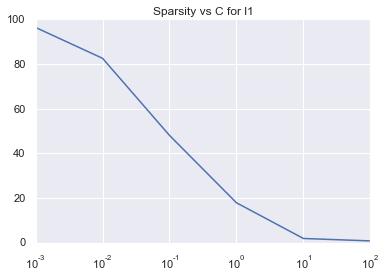

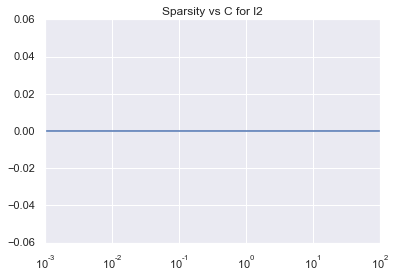

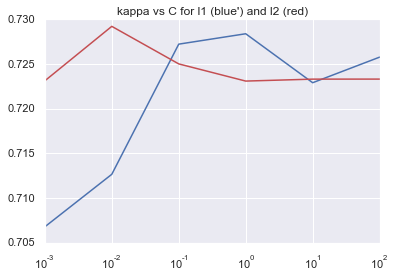

[[0.7067599455682856,
  0.7126421343449336,
  0.7272209732384451,
  0.7283850332087984,
  0.7229005159334516,
  0.725766505635072],
 [0.7231129093471624,
  0.7292136441528991,
  0.7250077583834457,
  0.723084278072121,
  0.7233016581325658,
  0.7233062384513378]]

In [65]:
predwake(X, y, X_test, y_true)

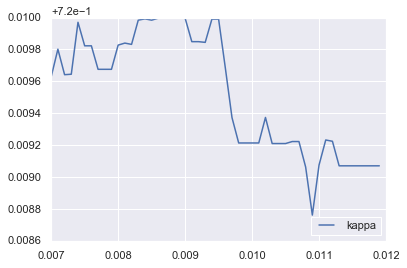

In [67]:

#predwake(X, y, X_test, y_true)
L = list(pd.Series(range(70, 120))/10000)
Lkappa_l2 = []

for C in L: 
    
    l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='liblinear')
 
    l2_LR.fit(X, y)
    y_pred_l2 = l2_LR.predict(X_test)


    kappa_l2 = cohen_kappa_score(y_true, y_pred_l2)
    Lkappa_l2.append(kappa_l2)


plt.plot(L, Lkappa_l2, label = "kappa")
plt.legend(loc='lower right')
plt.show()

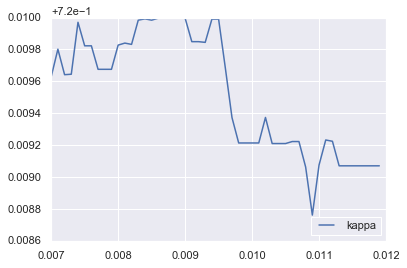

In [68]:

plt.plot(L, Lkappa_l2, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [89]:
l2_LR = LogisticRegression(C=0.009, penalty='l2', tol=0.01, solver='liblinear')
l2_LR.fit(train_proba11, y)
y_pred_l2 = l2_LR.predict(test_proba11)
kappa_l2 = cohen_kappa_score(y_true, y_pred_l2)
print(kappa_l2)

0.7295425544577583


# investigating colsample_bytree hyper parameter and gamma

reference
- 11 epoch with lambda=1: kappa = 0.7217
- 11 epoch with lambda=5: kappa = 0.7194

when colsample_bytree< 1, kappa lower than ref 

With gamma
- 11 epochs with lambda=5, gamma =0.1: Score 0.699, kappa 0.722

In [15]:
errors = []
Lk = []
La = []
i =11

train5 = reshape_n(train.iloc[:,:-1], i)
train5["Y"]= train.iloc[:,-1]

for j in range(0, i//2):
  train5.drop([train5.shape[0]-(i+1)], inplace=True)
test5 = reshape_n(test.iloc[:,:-1], i)
test5["Y"]= test.iloc[:,-1].values
for j in range(0, i//2):
  test5.drop([test5.shape[0]-(i+1)], inplace=True)

X = train5.iloc[:,:-1]
y = train5.iloc[:,-1]
X_test = test5.iloc[:,:-1]
y_true = test5.iloc[:,-1]
    

In [16]:
%%time 
errors = []
Lk = []
La = []

r= [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, colsample_bytree=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  0.3  epochs
log loss =  0.6086119295016064
kappa =  0.7130743266341769
accuracy =  0.7890651752083095
considering  0.4  epochs
log loss =  0.6113965018643105
kappa =  0.7128872660226054
accuracy =  0.7887227485446867
considering  0.5  epochs
log loss =  0.6100647303313382
kappa =  0.7152399844431047
accuracy =  0.7904348818628011
considering  0.6  epochs
log loss =  0.6104559147354545
kappa =  0.7161163760258439
accuracy =  0.7911197351900467
considering  0.7  epochs
log loss =  0.6082511610415079
kappa =  0.7130101933820053
accuracy =  0.7887227485446867
considering  0.8  epochs
log loss =  0.6078835241761458
kappa =  0.7183647487620287
accuracy =  0.7928318685081611
considering  0.9  epochs
log loss =  0.6144994850105288
kappa =  0.7149671571209648
accuracy =  0.7904348818628011
considering  1  epochs
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992
Wall time: 1h 27min 5s


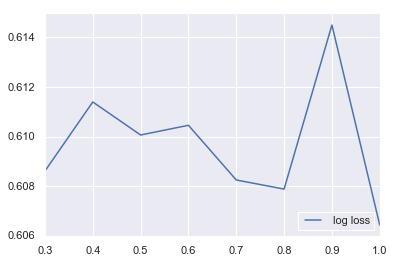

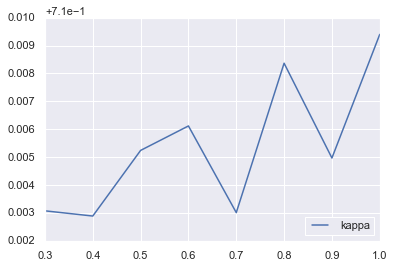

In [17]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [20]:
%%time 
errors = []
Lk = []
La = []
r= [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, colsample_bytree=1, gamma=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  0  epochs
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992
considering  0.1  epochs
log loss =  0.6046288458581158
kappa =  0.7220548768188264
accuracy =  0.7956854240383517
considering  0.2  epochs
log loss =  0.6054560586154966
kappa =  0.7191807515046349
accuracy =  0.7932884373929917
considering  0.3  epochs
log loss =  0.6066183845805189
kappa =  0.7144693226563926
accuracy =  0.7899783129779705
considering  0.4  epochs
log loss =  0.5996381263715957
kappa =  0.720972485326408
accuracy =  0.7945440018262755
considering  0.5  epochs
log loss =  0.5971507369108542
kappa =  0.7161543721742363
accuracy =  0.7911197351900467
Wall time: 1h 35min 21s


In [25]:
len(errors[-6:])

6

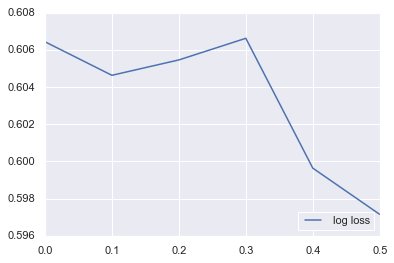

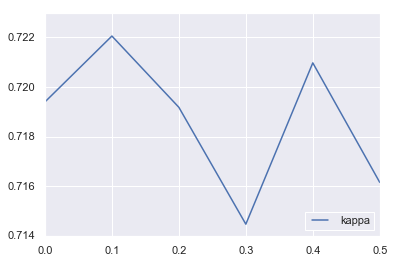

In [28]:
plt.plot(r, errors[-6:], label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk[-6:], label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [29]:
%%time 
errors = []
Lk = []
La = []
r= [0, 0.005, 0.1, 0.15]
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, colsample_bytree=1, gamma=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  0  epochs
log loss =  0.6064331996516102
kappa =  0.719398312246695
accuracy =  0.7934025796141992
considering  0.005  epochs
log loss =  0.6136662520306269
kappa =  0.7141459659746847
accuracy =  0.7897500285355553
considering  0.1  epochs
log loss =  0.6046288458581158
kappa =  0.7220548768188264
accuracy =  0.7956854240383517
considering  0.15  epochs
log loss =  0.6125348322264502
kappa =  0.7132133432902732
accuracy =  0.7888368907658942
Wall time: 1h 3min 57s


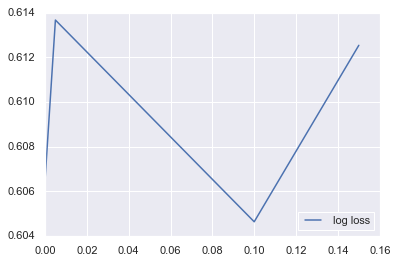

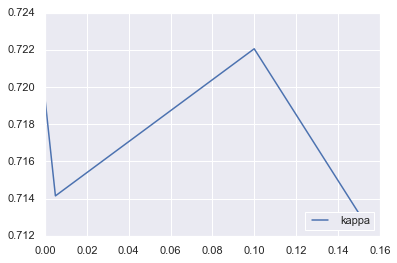

In [30]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [33]:
%%time 
errors = []
Lk = []
La = []
r= [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, colsample_bytree=1, gamma=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

considering  0.01  epochs
log loss =  0.6112722860664699
kappa =  0.715327193638036
accuracy =  0.7905490240840086
considering  0.02  epochs
log loss =  0.6100418826630304
kappa =  0.7179226623272709
accuracy =  0.7924894418445383
considering  0.03  epochs
log loss =  0.6194742997145054
kappa =  0.7112373048181171
accuracy =  0.7874671841114028
considering  0.04  epochs
log loss =  0.6156091952301944
kappa =  0.715719929714588
accuracy =  0.7908914507476316
considering  0.05  epochs
log loss =  0.6136240055119391
kappa =  0.7192714556532247
accuracy =  0.7935167218354069
considering  0.06  epochs
log loss =  0.6104936571522256
kappa =  0.7196033995708309
accuracy =  0.7936308640566145
considering  0.07  epochs
log loss =  0.6145528035110526
kappa =  0.714140599301528
accuracy =  0.78952174409314
considering  0.08  epochs
log loss =  0.6118658616103908
kappa =  0.7143676094128804
accuracy =  0.789864170756763
considering  0.09  epochs
log loss =  0.6075844205509069
kappa =  0.7156093637

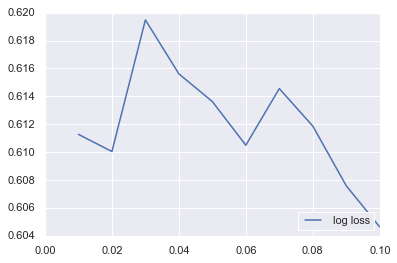

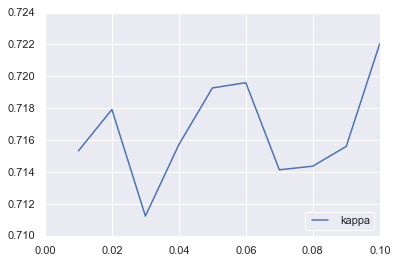

In [34]:
# reference
#log loss =  0.6064331996516102
#kappa =  0.719398312246695

plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

## Investigation tree_method=hist
reference
- 11 epoch with lambda=1: kappa = 0.7217
- 11 epoch with lambda=5: kappa = 0.7194

In [36]:
%%time 
errors = []
Lk = []
La = []

r= [256, 512, 1024]
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 8,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, tree_method="hist", max_bin=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[20:25:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  256  epochs
log loss =  0.6088491782404215
kappa =  0.717403052329346
accuracy =  0.7920328729597078
[20:48:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  512  epochs
log loss =  0.6116346628277889
kappa =  0.7157367864463167
accuracy =  0.7908914507476316
[21:24:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  1024  epochs
log loss =  0.6153418851307656
kappa =  0.7164131690780209
accuracy =  0.791348019632462
Wall time: 2h 1min 21s


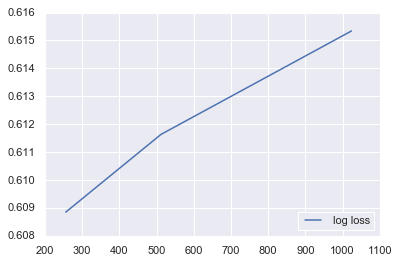

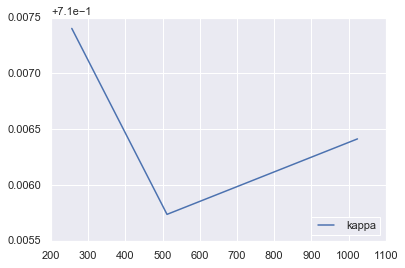

In [37]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [40]:
%%time 
errors = []
Lk = []
La = []

r= [31, 63, 123, 255, 511, 1023]
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 0,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[09:12:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  31  epochs
log loss =  0.5756948495217297
kappa =  0.7161963079659457
accuracy =  0.7907773085264239
[09:22:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  63  epochs
log loss =  0.5874116141645098
kappa =  0.7219784510929963
accuracy =  0.7954571395959366
[09:36:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  123  epochs
log loss =  0.6218889001652074
kappa =  0.7121162703394666
accuracy =  0.7878096107750256
[09:56:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  255  epochs
log loss =  0.6417133591729831
kappa =  0.7050494624500716
accuracy =  0.7824449263782673
[10:25:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  511  epochs
log loss =  0.6400870350037

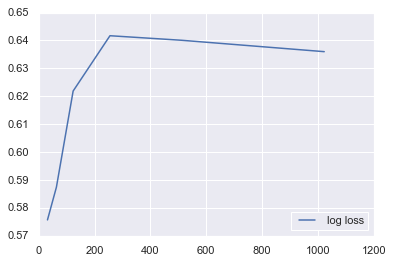

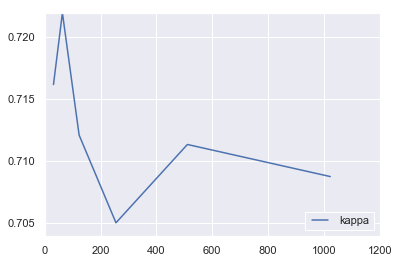

In [41]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [43]:
%%time 
errors = []
Lk = []
La = []

r= range(63-20, 63 +50, 10)
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 0,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[12:04:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  43  epochs
log loss =  0.5734980964716841
kappa =  0.7230304813346982
accuracy =  0.7960278507019747
[12:15:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  53  epochs
log loss =  0.5826647317318637
kappa =  0.7183506807634371
accuracy =  0.7926035840657459
[12:27:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  63  epochs
log loss =  0.5874116141645098
kappa =  0.7219784510929963
accuracy =  0.7954571395959366
[12:41:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  73  epochs
log loss =  0.595515865805028
kappa =  0.7204235537405717
accuracy =  0.794087432941445
[12:56:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  83  epochs
log loss =  0.6046985483381191
k

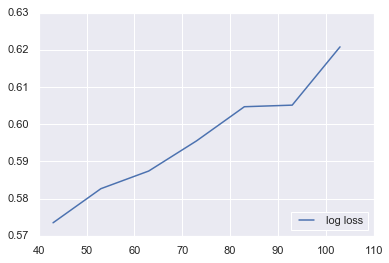

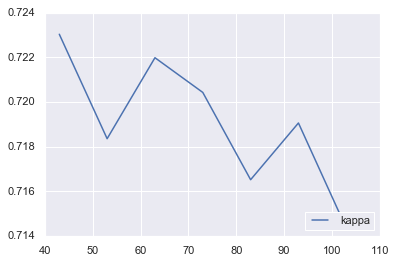

In [44]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [45]:
%%time 
errors = []
Lk = []
La = []

r= range(63-30, 50, 2)
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 0,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[14:01:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  33  epochs
log loss =  0.5722372111045229
kappa =  0.7169536340811136
accuracy =  0.7914621618536697
[14:11:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  35  epochs
log loss =  0.5749122267693848
kappa =  0.7198172012924724
accuracy =  0.7935167218354069
[14:21:58] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  37  epochs
log loss =  0.5798731203556207
kappa =  0.7192080006406509
accuracy =  0.7930601529505764
[14:33:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  39  epochs
log loss =  0.5762864569162707
kappa =  0.7192211939135085
accuracy =  0.7930601529505764
[14:44:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  41  epochs
log loss =  0.5744256424447488

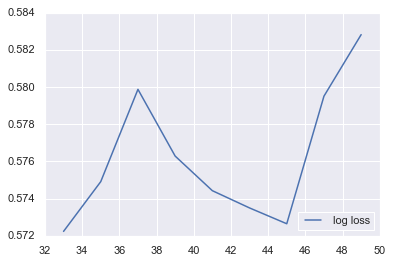

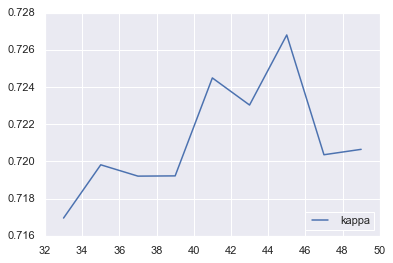

In [46]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [47]:
%%time 
errors = []
Lk = []
La = []

r= range(40, 47, 1)
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 180, random_state=42, learning_rate= 0.1, max_depth= 0,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[15:44:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  40  epochs
log loss =  0.5760494497478639
kappa =  0.7173047489834555
accuracy =  0.7918045885172925
[15:56:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  41  epochs
log loss =  0.5744256424447488
kappa =  0.7244877823513762
accuracy =  0.7969409884716356
[16:07:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  42  epochs
log loss =  0.5772179066111356
kappa =  0.7188768733746487
accuracy =  0.7929460107293688
[16:18:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  43  epochs
log loss =  0.5734980964716841
kappa =  0.7230304813346982
accuracy =  0.7960278507019747
[16:29:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  44  epochs
log loss =  0.5828432124237367

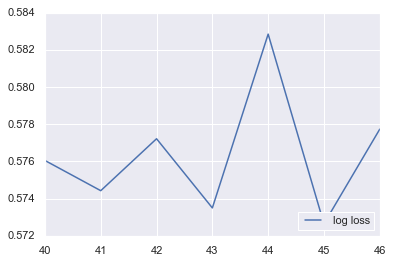

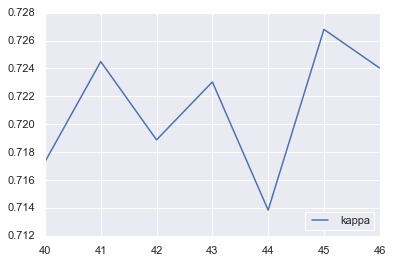

In [48]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [53]:
%%time 
errors = []
Lk = []
La = []

r= range(100, 210, 10)
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 0, subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=45)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[17:55:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  100  epochs
log loss =  0.5793875178752778
kappa =  0.7115161784171262
accuracy =  0.7872388996689875
[18:08:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  110  epochs
log loss =  0.5758812038529073
kappa =  0.7142295091282971
accuracy =  0.7892934596507248
[18:16:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  120  epochs
log loss =  0.5715101103340967
kappa =  0.7188982764583662
accuracy =  0.7928318685081611
[18:24:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  130  epochs
log loss =  0.5722014797137378
kappa =  0.719978583867237
accuracy =  0.7936308640566145
[18:32:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  140  epochs
log loss =  0.572097998350

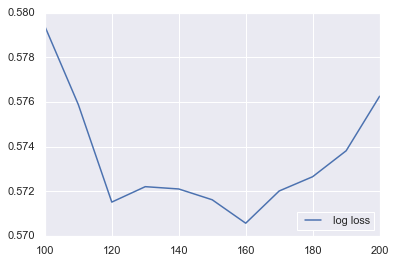

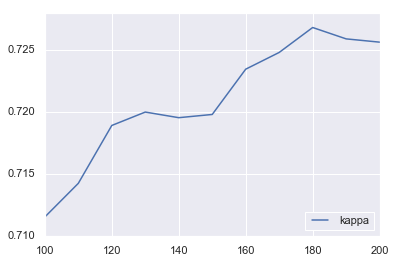

In [54]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

In [55]:
%%time 
#ref for n estimators = 180 and max_leave = 45
#log loss =  0.5705640711080483
#kappa =  0.7234370506106403

errors = []
Lk = []
La = []

r= range(40, 47, 1)
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 160, random_state=42, learning_rate= 0.1, max_depth= 0,  
                            subsample= 0.7, n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=i)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[09:10:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  40  epochs
log loss =  0.5745409764830749
kappa =  0.7166296800297802
accuracy =  0.7912338774112544
[09:19:38] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  41  epochs
log loss =  0.5729006504498307
kappa =  0.7223896273975867
accuracy =  0.7953429973747289
[09:29:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  42  epochs
log loss =  0.5729405709413395
kappa =  0.7201620093961629
accuracy =  0.7938591484990298
[09:38:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  43  epochs
log loss =  0.5679755703612387
kappa =  0.7230327352625863
accuracy =  0.7960278507019747
[09:48:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  44  epochs
log loss =  0.5788069139228145

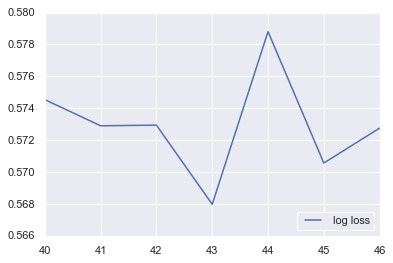

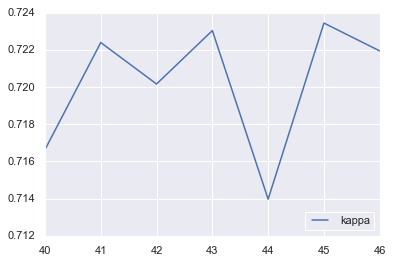

In [56]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

so lowest log loss is for leaves=43 (even if kappa is bit lower than for leaves=45)

In [57]:
%%time 
errors = []
Lk = []
La = []

r= range(100, 210, 10)
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = i, random_state=42, learning_rate= 0.1, max_depth= 0, subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=43)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[11:42:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  100  epochs
log loss =  0.571599081907119
kappa =  0.7149425030987564
accuracy =  0.789864170756763
[11:48:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  110  epochs
log loss =  0.5697055148447013
kappa =  0.7174232284602828
accuracy =  0.7918045885172925
[11:55:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  120  epochs
log loss =  0.566854908944482
kappa =  0.721711662352821
accuracy =  0.7950005707111061
[12:02:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  130  epochs
log loss =  0.5668017511212481
kappa =  0.7210188316269093
accuracy =  0.7945440018262755
[12:10:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  140  epochs
log loss =  0.565833164531193

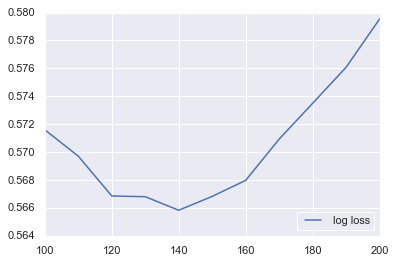

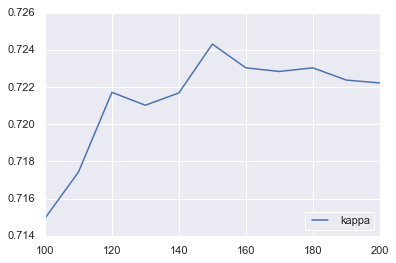

In [58]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()

best guess xgb.XGBClassifier(n_estimators = 150, random_state=42, learning_rate= 0.1, max_depth= 0, subsample= 0.7, 
                            n_jobs=-2, reg_lambda=5, tree_method="hist", grow_policy="lossguide", max_leaves=43)
- log loss =  0.566825786306174
- kappa =  0.7243058262553583


ref for n estimators = 180 and max_leave = 45
 - log loss =  0.5705640711080483
 - kappa =  0.7234370506106403


In [59]:
%%time 
errors = []
Lk = []
La = []

r= [1, 2, 3, 4, 5, 6, 7]
for i in r:
          
    xbc = xgb.XGBClassifier(n_estimators = 150, random_state=42, learning_rate= 0.1, max_depth= 0, subsample= 0.7, 
                            n_jobs=-2, reg_lambda=i, tree_method="hist", grow_policy="lossguide", max_leaves=43)
    xbc.fit(X, y)
    ll = log_loss(y_true, xbc.predict_proba(X_test))
    errors.append(ll)
    y_pred = xbc.predict(X_test)
    k=cohen_kappa_score(y_true, y_pred)
    a= accuracy_score(y_true, y_pred)
    print("considering ", i, " epochs")
    print("log loss = ", ll)
    print("kappa = ", k)
    print("accuracy = ", a)
    Lk.append(k)
    La.append(a)

[14:15:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  1  epochs
log loss =  0.5819073870438565
kappa =  0.7144896633578612
accuracy =  0.7897500285355553
[14:24:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  2  epochs
log loss =  0.5761513976334146
kappa =  0.7189237120906333
accuracy =  0.7928318685081611
[14:33:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  3  epochs
log loss =  0.5830384376620139
kappa =  0.714297168028641
accuracy =  0.7891793174295172
[14:42:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  4  epochs
log loss =  0.5784721487402358
kappa =  0.7181443602498385
accuracy =  0.792261157402123
[14:50:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
considering  5  epochs
log loss =  0.566825786306174
kappa =

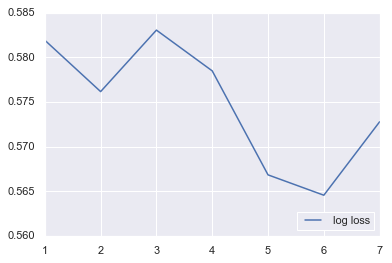

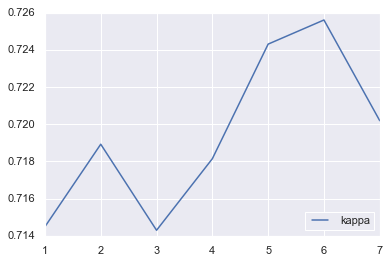

In [60]:
plt.plot(r, errors, label = "log loss")
plt.legend(loc='lower right')
plt.show()
#plt.plot(r, La, label = "accuracy")
plt.plot(r, Lk, label = "kappa")
plt.legend(loc='lower right')
plt.show()


best guess xgb.XGBClassifier(n_estimators = 150, random_state=42, learning_rate= 0.1, max_depth= 0, subsample= 0.7, 
                            n_jobs=-2, reg_lambda=6, tree_method="hist", grow_policy="lossguide", max_leaves=43)
- log loss =  0.5645452888026713
- kappa =  0.7256029099027044